<a href="https://colab.research.google.com/github/devansurf/CoralSight-Binary/blob/main/CoralSight_Binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoralSight Binary
Computer vision model to differentiate between bleached and non-bleached corals

In [162]:
#Fetch dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [163]:
#Libaries
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
#import optuna #tuner
import re
import random
import seaborn as sns
from collections import Counter
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.nn import Module, Conv2d, ConvTranspose2d, Dropout, BatchNorm2d
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import random_split


from PIL import Image

from collections import Counter
from tqdm import tqdm
from IPython.display import display, Math, Latex
from sklearn.utils import resample
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split

In [164]:
#directories
bleached_corals_dir = '/content/drive/MyDrive/MachineLearning/coral-dataset/bleached_corals'
healthy_corals_dir = '/content/drive/MyDrive/MachineLearning/coral-dataset/healthy_corals'

In [165]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [166]:
def to_numpy(x):

    return x.detach().cpu().numpy()

In [167]:
#Configuration
class Config:
    learning_rate = 0.00005
    num_epochs = 30
    batch_size = 32
    dropout = 0.7

    img_dimensions = (128, 128)

    training_proportion = 0.7
    validation_proportion = 0.2

In [168]:
class CoralDataset(Dataset):
    def __init__(self, bleached_dir, healthy_dir, transform=None):
        self.bleached_images = [os.path.join(bleached_dir, img) for img in os.listdir(bleached_dir)]
        self.healthy_images = [os.path.join(healthy_dir, img) for img in os.listdir(healthy_dir)]

        # Combine and label images: 0 for bleached, 1 for healthy
        self.all_images = self.bleached_images + self.healthy_images
        self.labels = [0] * len(self.bleached_images) + [1] * len(self.healthy_images)

        self.transform = transform

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, index):
        img_path = self.all_images[index]
        label = self.labels[index]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [169]:
class CoralCNN(nn.Module):
    def __init__(self, dropout=0.5):
        super(CoralCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjust the size (this is for 128x128)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Adjust the size (this is for 128x128)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [170]:
def train_model(learning_rate, num_epochs, dropout, train_loader, valid_loader):
    model = CoralCNN(dropout=dropout)
    if torch.cuda.is_available():
        model = model.cuda()

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

    acc_hist_train = []
    acc_hist_val = []

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            predicted = torch.round(outputs.data.squeeze())  # Round to 0 or 1
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        acc_hist_train.append(train_accuracy)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()

                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels.float())

                valid_loss += loss.item() * images.size(0)

                predicted = torch.round(outputs.data.squeeze())
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_accuracy = correct_val / total_val
        acc_hist_val.append(valid_accuracy)
        val_losses.append(valid_loss)

        print(f"Epoch: {epoch}")
        print(f"Train Acc: {train_accuracy:.3f}")
        print(f"Val Acc: {valid_accuracy:.3f}")
        print(f"Train Loss: {train_loss:.3f}")
        print(f"Val Loss: {valid_loss:.3f}")
        print("---------------------------------------------")

    #model = CoralCNN(dropout)
    model.eval()
    return model, acc_hist_train, acc_hist_val, train_losses, val_losses

**Create the Dataset with the specified transform (augmentation)** 😀

In [171]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(Config.img_dimensions),
    transforms.ToTensor()
])

dataset = CoralDataset(bleached_corals_dir, healthy_corals_dir, transform=transform)

#calculate lengths
total_size = len(dataset)
train_size = int(total_size * Config.training_proportion)
valid_size = int(total_size * Config.validation_proportion)
test_size = total_size - train_size - valid_size

# Split the dataset
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

#creating data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False)


**Display some images and labels for reference**

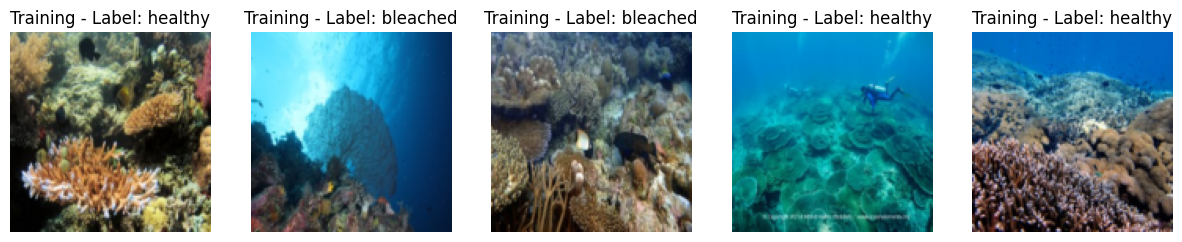

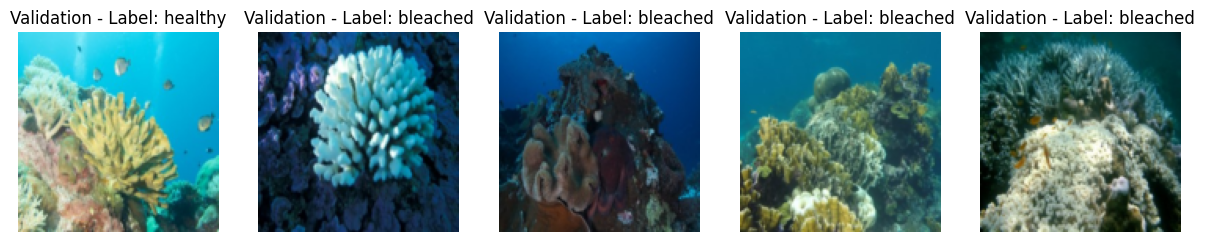

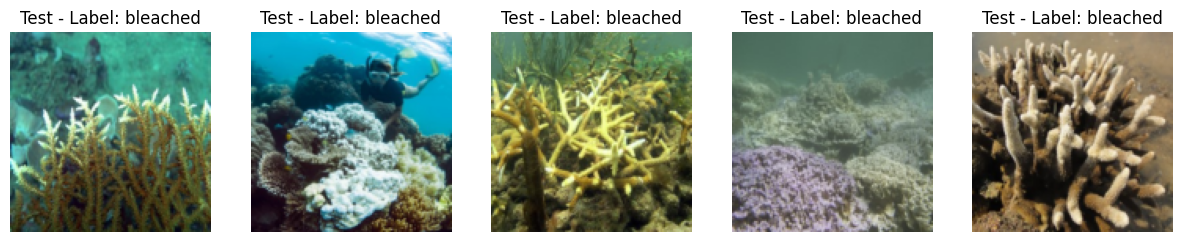

In [172]:
def show_random_images(subset, subset_name, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Randomly select an index
        idx = random.randint(0, len(subset) - 1)

        # Get the image and label
        image, label= subset[idx]
        label = 'bleached' if label == 0 else 'healthy'
        # Convert the tensor image to a NumPy array for visualization
        image_np = image.permute(1, 2, 0).numpy()

        # Subplot for each image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_np)
        plt.title(f'{subset_name} - Label: {label}')
        plt.axis('off')

    plt.show()

show_random_images(train_dataset, 'Training', num_images=5)
show_random_images(valid_dataset, 'Validation', num_images=5)
show_random_images(test_dataset, 'Test', num_images=5)

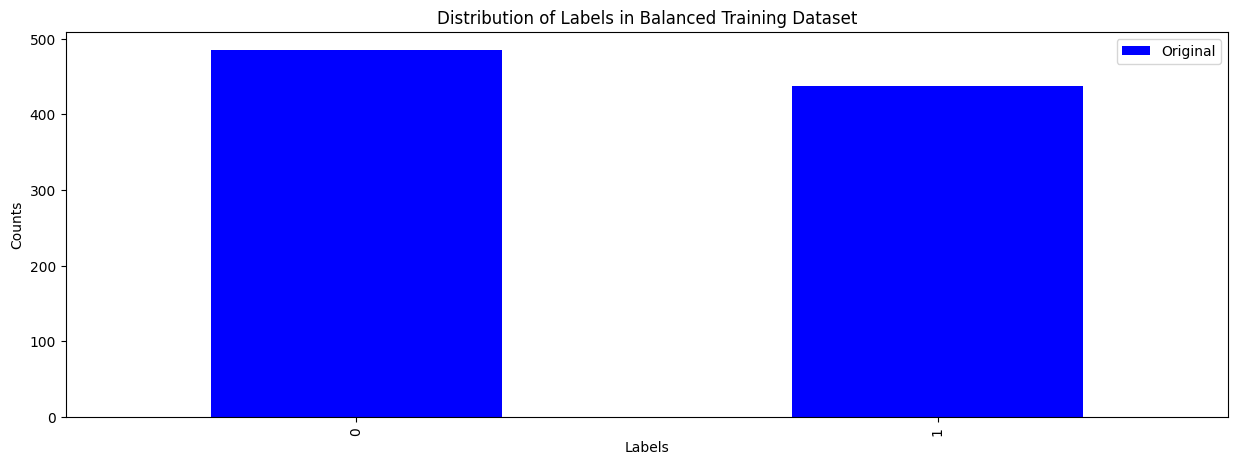

In [173]:
counts = {}
for _, label in dataset:
    if label in counts:
        counts[label] += 1
    else:
        counts[label] = 1

counts_series = pd.Series(counts)

# Plot the label counts
plt.figure(figsize=(15, 5))
# Plot original counts
counts_series.plot(kind='bar', color='blue', label='Original')

plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('Distribution of Labels in Balanced Training Dataset')
plt.legend()
plt.show()

**Train the model !!!!**

In [174]:
model, acc_hist_train, acc_hist_val, train_losses, val_losses = train_model(Config.learning_rate, Config.num_epochs, Config.dropout, train_loader, valid_loader)

100%|██████████| 21/21 [00:02<00:00,  7.26it/s]


Epoch: 0
Train Acc: 0.533
Val Acc: 0.620
Train Loss: 0.686
Val Loss: 0.667
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.98it/s]


Epoch: 1
Train Acc: 0.642
Val Acc: 0.690
Train Loss: 0.657
Val Loss: 0.625
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.11it/s]


Epoch: 2
Train Acc: 0.669
Val Acc: 0.696
Train Loss: 0.619
Val Loss: 0.595
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.70it/s]


Epoch: 3
Train Acc: 0.684
Val Acc: 0.717
Train Loss: 0.590
Val Loss: 0.565
---------------------------------------------


100%|██████████| 21/21 [00:03<00:00,  5.30it/s]


Epoch: 4
Train Acc: 0.709
Val Acc: 0.739
Train Loss: 0.565
Val Loss: 0.545
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.13it/s]


Epoch: 5
Train Acc: 0.720
Val Acc: 0.734
Train Loss: 0.565
Val Loss: 0.545
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.23it/s]


Epoch: 6
Train Acc: 0.718
Val Acc: 0.745
Train Loss: 0.560
Val Loss: 0.539
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.01it/s]


Epoch: 7
Train Acc: 0.723
Val Acc: 0.739
Train Loss: 0.540
Val Loss: 0.529
---------------------------------------------


100%|██████████| 21/21 [00:03<00:00,  6.78it/s]


Epoch: 8
Train Acc: 0.723
Val Acc: 0.750
Train Loss: 0.534
Val Loss: 0.529
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.99it/s]


Epoch: 9
Train Acc: 0.728
Val Acc: 0.734
Train Loss: 0.535
Val Loss: 0.531
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.88it/s]


Epoch: 10
Train Acc: 0.721
Val Acc: 0.750
Train Loss: 0.530
Val Loss: 0.526
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.91it/s]


Epoch: 11
Train Acc: 0.735
Val Acc: 0.761
Train Loss: 0.523
Val Loss: 0.516
---------------------------------------------


100%|██████████| 21/21 [00:03<00:00,  6.79it/s]


Epoch: 12
Train Acc: 0.724
Val Acc: 0.750
Train Loss: 0.516
Val Loss: 0.514
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.44it/s]


Epoch: 13
Train Acc: 0.737
Val Acc: 0.739
Train Loss: 0.510
Val Loss: 0.515
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.03it/s]


Epoch: 14
Train Acc: 0.729
Val Acc: 0.766
Train Loss: 0.517
Val Loss: 0.516
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.09it/s]


Epoch: 15
Train Acc: 0.738
Val Acc: 0.750
Train Loss: 0.520
Val Loss: 0.507
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.32it/s]


Epoch: 16
Train Acc: 0.734
Val Acc: 0.761
Train Loss: 0.514
Val Loss: 0.504
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.08it/s]


Epoch: 17
Train Acc: 0.748
Val Acc: 0.755
Train Loss: 0.500
Val Loss: 0.501
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.04it/s]


Epoch: 18
Train Acc: 0.735
Val Acc: 0.761
Train Loss: 0.503
Val Loss: 0.526
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.03it/s]


Epoch: 19
Train Acc: 0.755
Val Acc: 0.750
Train Loss: 0.500
Val Loss: 0.504
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.86it/s]


Epoch: 20
Train Acc: 0.735
Val Acc: 0.772
Train Loss: 0.510
Val Loss: 0.496
---------------------------------------------


100%|██████████| 21/21 [00:03<00:00,  6.75it/s]


Epoch: 21
Train Acc: 0.745
Val Acc: 0.761
Train Loss: 0.506
Val Loss: 0.503
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.13it/s]


Epoch: 22
Train Acc: 0.766
Val Acc: 0.783
Train Loss: 0.492
Val Loss: 0.495
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.06it/s]


Epoch: 23
Train Acc: 0.768
Val Acc: 0.772
Train Loss: 0.489
Val Loss: 0.491
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.12it/s]


Epoch: 24
Train Acc: 0.755
Val Acc: 0.761
Train Loss: 0.493
Val Loss: 0.491
---------------------------------------------


100%|██████████| 21/21 [00:03<00:00,  6.81it/s]


Epoch: 25
Train Acc: 0.771
Val Acc: 0.772
Train Loss: 0.473
Val Loss: 0.486
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.72it/s]


Epoch: 26
Train Acc: 0.751
Val Acc: 0.788
Train Loss: 0.497
Val Loss: 0.483
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.18it/s]


Epoch: 27
Train Acc: 0.755
Val Acc: 0.783
Train Loss: 0.486
Val Loss: 0.483
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  8.15it/s]


Epoch: 28
Train Acc: 0.772
Val Acc: 0.783
Train Loss: 0.468
Val Loss: 0.498
---------------------------------------------


100%|██████████| 21/21 [00:02<00:00,  7.32it/s]


Epoch: 29
Train Acc: 0.776
Val Acc: 0.799
Train Loss: 0.474
Val Loss: 0.480
---------------------------------------------


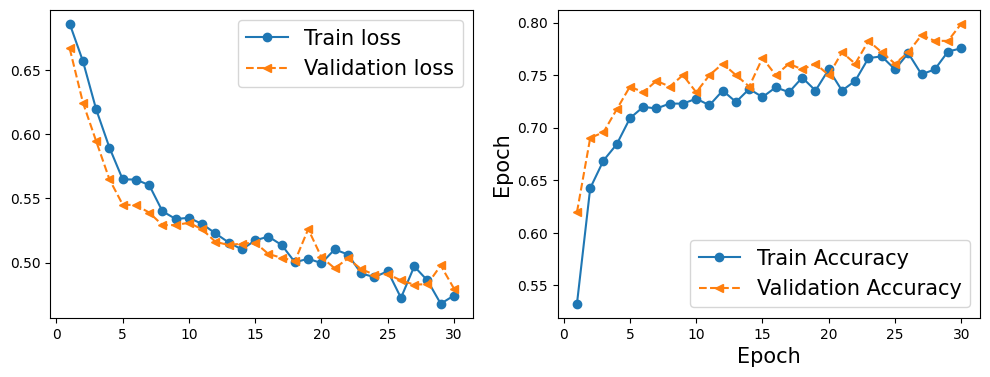

In [175]:
#Plot graphs
x_axis = np.arange(Config.num_epochs) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)

ax.plot(x_axis, train_losses, '-o', label = 'Train loss')
ax.plot(x_axis, val_losses, '--<', label = 'Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_axis, acc_hist_train, '-o', label='Train Accuracy')
ax.plot(x_axis, acc_hist_val, '--<', label='Validation Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Epoch', size=15)
plt.show()

In [176]:
#Final results
total_correct = 0
total_samples = 0
actual_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        pred = model(x)  # predict, this should output the probability of being class '1' (e.g., 'healthy')
        predictions = torch.round(pred.squeeze()) # Threshold at 0.5; if pred >= 0.5, predictions = 1

        total_correct += (predictions == y).sum().item()
        total_samples += y.size(0)

        actual_labels.extend(to_numpy(y))
        predicted_labels.extend(to_numpy(predictions))

accuracy_test = total_correct / total_samples

print(f'test accuracy: {accuracy_test}')
print("NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.")
F1_score = f1_score(actual_labels, predicted_labels, average='macro')
print(f'F1_score: {F1_score}')

test accuracy: 0.8172043010752689
NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.
F1_score: 0.8164402647161267


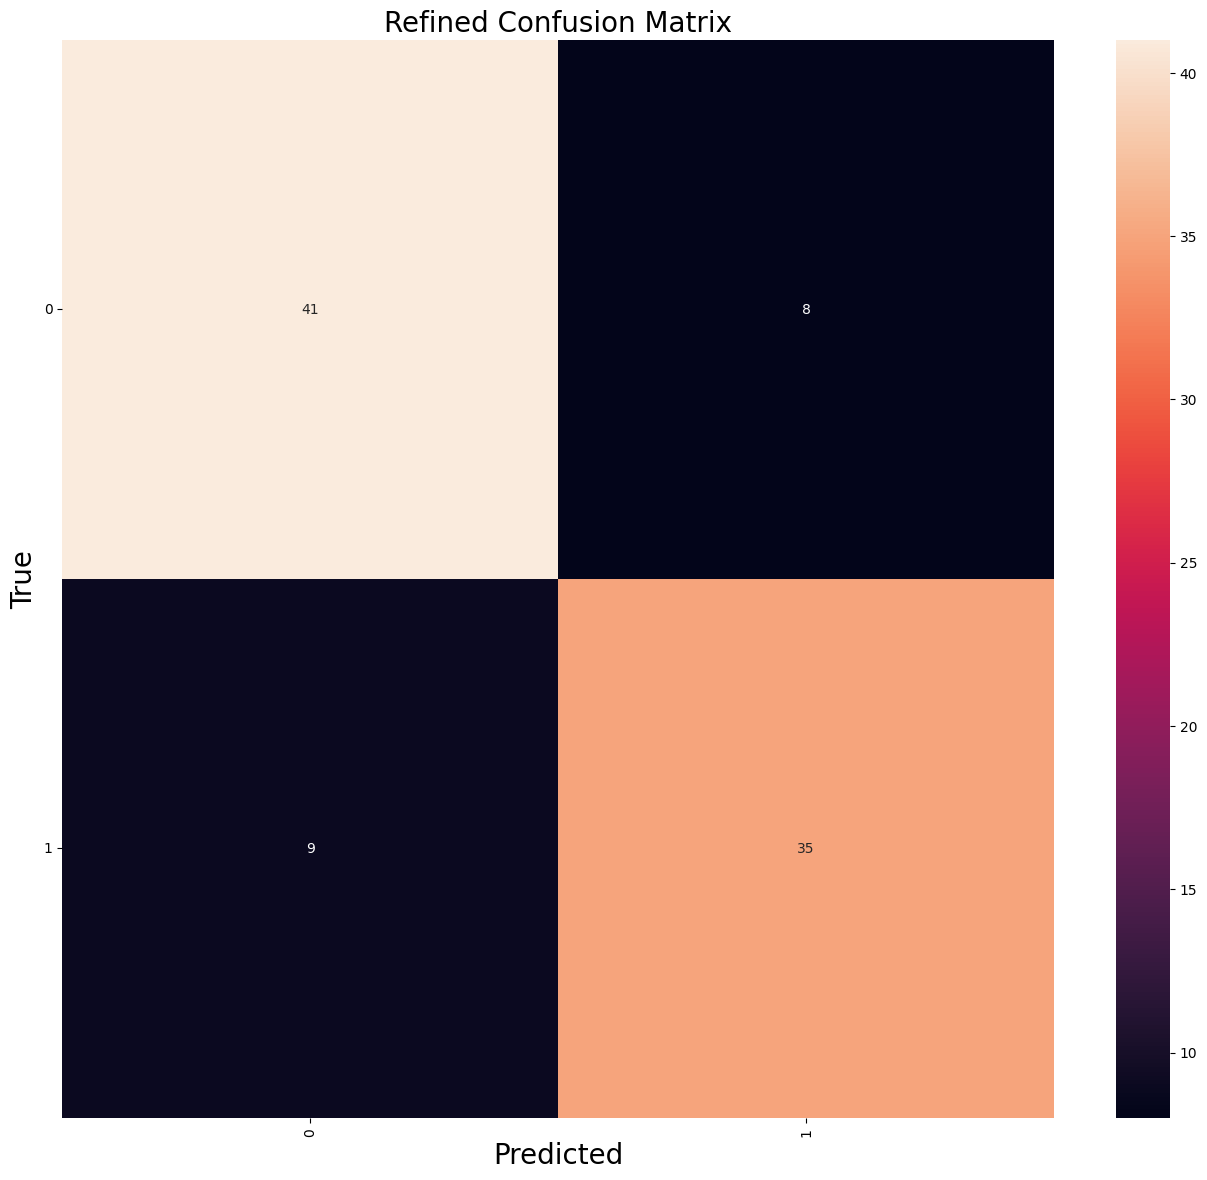

f1_score: 0.8164402647161267


In [177]:
#Confusion matrix:
cm = confusion_matrix(actual_labels, predicted_labels)

labels = list(set(dataset.labels))

fig = plt.figure(figsize=(16, 14))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="g")
ax.set_xlabel("Predicted", fontsize=20)
ax.xaxis.set_label_position("bottom")
plt.xticks(rotation=90)
ax.xaxis.tick_bottom()

ax.set_ylabel("True", fontsize=20)
plt.yticks(rotation=0)

plt.title("Refined Confusion Matrix", fontsize=20)

plt.show()

F1_score = f1_score(actual_labels, predicted_labels, average='macro')

print(f'f1_score: {F1_score}')